# Finding a Minimal Set of Graphs for Impossibility Theorems

In [1]:
from itertools import product, combinations
import pickle
import networkx as nx # for graphs
import matplotlib.pyplot as plt
from pysat.solvers import Glucose3 # SAT solver
from tqdm.notebook import tqdm
from pysat.formula import CNF 


## 1. Minimal set of tournaments to prove Proposition A.12

Naively, one approach to obtaining a minimal set of tournaments is the following: 
1. Generate a CNF using all relevant tournaments.
2. Run PicoMUS on the CNF to obtain an MUS.
3. Extract the set of tournaments associated with literals in the MUS.
4. Use the extracted set of graphs to re-generate a CNF and verify unsatisfiability. 

However, this approach may fail at step 4; the extracted set of tournaments may lead to a satisfiability result.  The reason is that a clause in step 1 may be generated in part because of an embedding of a tournament $T$ into $T'$ although the clause does not contain literals associated with both $T$ and $T'$.   To solve this problem, we keep track of all tournaments responsible for the inclusion of a literal in the CNF.  Then, we use this information to extract a larger set of tournaments in step 3, and we verify that this larger set of tournaments does indeed lead to an unsatisfiability result. 

It is also useful in analyzing the MUS to know the "reason" why each clause was added to the orignal CNF, i.e., whether it was part of binary $\gamma$, $\alpha$-resoluteness, etc., and what is the relevant emdedding between tournaments.  So, we have added code to keep track of these reasons.  


In [2]:
# Paths to pickled weak tournaments
canonical_weak_tournament_paths = {
    2: 'weak_tourns/weak_tourns_2.pkl',
    3: 'weak_tourns/weak_tourns_3.pkl',
    4: 'weak_tourns/weak_tourns_4.pkl',
    5: 'weak_tourns/weak_tourns_5.pkl',
#    6: 'weak_tourns/weak_tourns_6.pkl',
#    7: 'weak_tourns/weak_tourns_7.pkl',
}

# Load all the canonical tournaments
canonical_weak_tournaments = {nc: pickle.load(open(canonical_weak_tournament_paths[nc], 'rb'))
                              for nc in range(2,6)}


# Paths to pickled weak tournaments
canonical_tournament_paths = {
    2: 'tourns/tourns_2.pkl',
    3: 'tourns/tourns_3.pkl',
    4: 'tourns/tourns_4.pkl',
    5: 'tourns/tourns_5.pkl',
    6: 'tourns/tourns_6.pkl',
#    7: 'tourns/tourns_7.pkl',
}


# Load all the canonical tournaments
canonical_tournaments = {nc: pickle.load(open(canonical_tournament_paths[nc], 'rb'))
                         for nc in range(2,7)}


In [3]:
def display_wt(wt):
    """Display a (weak) tournament"""
    pos = nx.circular_layout(wt)
    nx.draw(wt, pos, font_size=20, node_color='blue', font_color='white', 
            node_size = 700, width=1, with_labels=True)
    plt.show()

def is_maj_preferred(wt, c1, c2): 
    """True if c1 is majority preferred to c2"""
    return wt.has_edge(c1, c2)

def is_tournament(wt):
    """test if a weak tournament is a tournament"""
    candidates = wt.nodes
    is_t = True
    for c1 in candidates: 
        for c2 in candidates: 
            if c1 != c2 and not is_maj_preferred(wt,c1,c2) and not is_maj_preferred(wt,c2,c1):
                is_t = False
    return is_t

def findsubsets(s, n):
    """all subsets of the list s of size n""" 
    return [set(i) for i in combinations(s, n)] 

def powerset_ne(fullset):
    """return all non-empty subsets of fullset"""
    listrep = list(fullset)
    n = len(listrep)
    all_subsets = [[listrep[k] for k in range(n) if i&1<<k ] for i in range(2**n)]
    return [sorted(s) for s in all_subsets if len(s) > 0]

def all_included(listlike, items):
    """
    helper for powerset_ne_plus
    returns true if all members of items are in listlike
    """
    for item in items:
        if item not in listlike:
            return False
    return True

def powerset_ne_plus(listlike, items):
    """returns all non-empty subsets of setlike which include elements of items"""
    return [sorted(pset) for pset in powerset_ne(listlike) if all_included(pset, items)]

In [4]:
def orbit_condition(orbit, ws): 
    """
    orbit is a set of candidates and ws is a winning set
    returns true if the orbit condition is satisfied
    """
    return set(orbit).issubset(set(ws)) or not bool(set(orbit).intersection(set(ws)))

def find_possible_winners(min_num_cands, max_num_cands, canonical_graphs): 
    """
    takes dictionary of canonical graphs and range of graph sizes to consider
    for each canonical graph, creates tuples containing the graph and winning sets that satisfy the orbit condition
    """
    possible_winners = {nc: list() for nc in range(min_num_cands, max_num_cands + 1)}
    for nc in possible_winners.keys():
        for g in canonical_graphs[nc]:
            candidates = g.nodes

            # all the automorophism on wt
            automorphisms = list(nx.algorithms.isomorphism.GraphMatcher(g, g).isomorphisms_iter())

            # find the orbits
            _orbits=list()
            for c in candidates: 
                _orbit = list()
                for aut in automorphisms: 
                    _orbit.append(aut[c])
                _orbits.append(tuple(set(_orbit)))
            orbits = list(set(_orbits))

            # find the possible winning sets for wt
            for ws in powerset_ne(candidates): 
                if all([orbit_condition(orbit, ws) for orbit in orbits]):
                    possible_winners[nc].append((g, ws))
    return possible_winners

def generate_wt_dictionary(possible_winners):
    """
    takes a dictionary of (weak) tournaments and returns a dictionary (t, ws) -> int
    t is a tournament in 'possible_winners' and ws is a winning set on t satisfying the orbit condition
    """
    wt_dictionary = {}
    wt_id = 1
    for nc in possible_winners.keys(): 
        for wt, ws in possible_winners[nc]:
            wt_dictionary.update({(wt, tuple(ws)): wt_id})
            wt_id += 1
            
    return wt_dictionary

In [5]:
def generate_function_formula(graphs, wt_dictionary): 
    """
    takes a list of all graphs 'graphs' and a dictionary of possible winners on those graphs 'wt_dictionary'
    returns CNF clauses ensuring that only one winning set will be chosen per graph
    """
    C_func = list()
    for g in graphs:     
        # get the list of all atomic formulas describing a possible winning set
        poss_ws = [wt_dictionary[(_g, ws)] for _g,ws in wt_dictionary.keys() if _g == g]
        # NOTE: we use equality rather than testing for graph isomporphism.  This makes sense since
        # graphs is the set of the networkx objects representing the canonical weak tournaments and 
        # the keys of wt_dictionary are tuples where the first components is an object from this lest. 
        C_func.append(poss_ws) # one of the possible winning sets is the winner
        for pairs in combinations(poss_ws, 2):
            # add a clause saying that it is not the case that two possible winning sets are associated 
            # with a single weak tournament
            C_func.append([0 - pairs[0], 0 - pairs[1]])

    return C_func


In [6]:
def is_embedding(small_g, big_g, iso):
    """
    iso is an isomorphism from small_g to a subgraph of big_g,
    but we must check whether iso is an embedding. 
    returns True if iso is an embedding of small_g into big_g. 
    
    Returns True if for every pair of candidates c1 and c2 in small_g, 
    if there is an edge between iso[c1] and iso[c2] in big_g, then 
    there is an edge between c1 and c2 in small_g
    """
    for c1, c2 in product(small_g.nodes, small_g.nodes): 
        if big_g.has_edge(iso[c1],iso[c2]) and not small_g.has_edge(c1,c2):
            return False
    return True  

def find_embeddings(min_num_cands, max_num_cands, canonical_graphs):
    """
    find embeddings of graphs in 'canonical_graphs',
    embeddings of n-tournaments to (n+1)-tournaments, for n=min_num_cands,...,max_num_cands-1
    """
    embeddings = list()

    for nc in range(min_num_cands, max_num_cands): 
        # for each number of candidate between min_num_cands and max_num_cands - 1  

        for g1 in canonical_graphs[nc]: 
            # for each canonical graph of size nc    

            for g2 in canonical_graphs[nc+1]:
                # for each canonical graph of size nc+1

                seen_ranges = set()

                for iso in nx.algorithms.isomorphism.GraphMatcher(g2, g1).subgraph_isomorphisms_iter():
                    # for each isomporphism from g1 to a subgraph of g2

                    # NOTE: iso is a dictionary associating a subset of nodes from g2 to the nodes in g1
                    # It's easier to think about the isomorphism as a mapping from the smaller graph g1 
                    # into the bigger graph g2:
                    inverse_iso = {v:k for k,v in iso.items()}

                    rng = tuple(sorted(iso.keys())) # the range of the isomorphism (nodes in the bigger graph)
                    if not rng in seen_ranges and is_embedding(g1, g2, inverse_iso): 
                        # if haven't seen the range yet and g1 is an embedding into g2
                        seen_ranges.add(rng)
                        # record the smaller graph g1, larger graph g2 and isomorphism from g1 to g2
                        embeddings.append((g1, g2, inverse_iso))  
    return embeddings

In [7]:
def generate_bg_formula(min_num_cands,
                        max_num_cands, 
                        canonical_graphs, 
                        wt_dictionary, 
                        possible_winners, 
                        embeddings,
                        two_cand_tournament
                       ): 
    """
    returns CNF clauses expressing binary gamma
    """
    

    maj_winner = [c for c in two_cand_tournament.nodes if two_cand_tournament.out_degree(c) == 1]
    non_maj_winner = [c for c in two_cand_tournament.nodes if c not in maj_winner]
    
    can_2_maj_pref_cand_literal = wt_dictionary[(two_cand_tournament, tuple(maj_winner))]
    can_2_min_pref_cand_literal = wt_dictionary[(two_cand_tournament, tuple(non_maj_winner))]
    
    C_bg = list()

    for nc in range(min_num_cands, max_num_cands + 1):

        for t1 in canonical_graphs[nc]:
            # for each canonical graph for nc candidates
            
            for emb in [_emb for _emb in embeddings if _emb[0] == t1]: 
                # for each possible embedding from t1 into a canonical graph emb[1]
                
                t2 = emb[1]
                # t2 is a canonical graph on nc+1 candidates, which t1 embeds into
                
                if t2 in canonical_graphs[nc+1]:
                    new_cand = list(set(emb[1].nodes).difference(set(emb[2].values())))[0]
                    # new_cand is the candidate in t2 not in the range of the embedding from t1 to t2

                    for cand in t1.nodes:
                        cand_t2 = emb[2][cand]
                        if (cand_t2, new_cand) in t2.edges: # if cand_t2 is majority preferred to new_cand
                            for ws in [_ws for _ws in powerset_ne_plus(t1.nodes, [cand]) if (t1, tuple(_ws)) in wt_dictionary]:
                                # for winning sets in t1 including cand (i.e. if cand (pre-image of cand_t2) is a winner in t1)
                                clause = [-wt_dictionary[(t1, tuple(ws))],
                                         -can_2_maj_pref_cand_literal]  
                                # if majority preference holds on the two-candidate tournament
                                clause += [wt_dictionary[(t2, tuple(_ws))] \
                                           for _ws in powerset_ne_plus(t2.nodes, [cand_t2]) \
                                           if (t2, tuple(_ws)) in wt_dictionary]
                                # then cand_t2 is a winner in t2

                                if tuple(clause) in clause_reasons.keys(): 
                                    clause_reasons[tuple(clause)].append(("BG", emb[0], emb[1], emb[2]))
                                else: 
                                    clause_reasons[tuple(clause)] = [("BG", emb[0], emb[1], emb[2])]


                                C_bg.append(clause)

                        elif (new_cand, cand_t2) in t2.edges: # if cand_t2 is minority preferred to new_cand
                            for ws in [_ws for _ws in powerset_ne_plus(t1.nodes, [cand]) if (t1, tuple(_ws)) in wt_dictionary]:
                                # for winning sets in t1 including cand (i.e. if cand (pre-image of cand_t2) is a winner in t1)
                                clause = [-wt_dictionary[(t1, tuple(ws))],
                                         -can_2_min_pref_cand_literal]
                                # if minority preference holds on the two-candidate tournament
                                clause += [wt_dictionary[(t2, tuple(_ws))] \
                                           for _ws in powerset_ne_plus(t2.nodes, [cand_t2]) \
                                           if (t2, tuple(_ws)) in wt_dictionary]
                                # then cand_t2 is a winner in t2

                                if tuple(clause) in clause_reasons.keys(): 
                                    clause_reasons[tuple(clause)].append(("BG", emb[0], emb[1], emb[2]))
                                else: 
                                    clause_reasons[tuple(clause)] = [("BG", emb[0], emb[1], emb[2])]

                                C_bg.append(clause)

                        else:
                            raise Exception
                        
    return C_bg

In [8]:
def generate_ar_formula(min_num_cands, 
                         max_num_cands, 
                         canonical_graphs, 
                         wt_dictionary, 
                         possible_winners, 
                         embeddings,
                        two_cand_tournament
                       ): 
    """
    returns CNF clauses expressing binary alpha
    """
    
    maj_winner = [c for c in two_cand_tournament.nodes if two_cand_tournament.out_degree(c) == 1]
    non_maj_winner = [c for c in two_cand_tournament.nodes if c not in maj_winner]
    
    can_2_maj_pref_cand_literal = wt_dictionary[(two_cand_tournament, tuple(maj_winner))]
    can_2_min_pref_cand_literal = wt_dictionary[(two_cand_tournament, tuple(non_maj_winner))]

    C_ar = list()

    for nc in range(min_num_cands, max_num_cands + 1):

        for t1 in canonical_graphs[nc]:
            # for each canonical graph for nc candidates
            
            for emb in [_emb for _emb in embeddings if _emb[0] == t1]: 
                # for each possible embedding from t1 into a canonical graph emb[1]
                
                t2 = emb[1]
                
                if t2 in canonical_graphs[nc+1]:
                    # t2 is a canonical graph on nc+1 candidates, which t1 embeds into

                    new_cand = list(set(emb[1].nodes).difference(set(emb[2].values())))[0]
                    # new_cand is the candidate in t2 not in the range of the embedding from t1 to t2
                    for cand in t1.nodes:
                        cand_t2 = emb[2][cand]

                        if (cand_t2, new_cand) in t2.edges: # if cand_t2 is majority preferred to new_cand
                            for ws in [_ws for _ws in powerset_ne_plus(t1.nodes, [cand]) if (t1, tuple(_ws)) in wt_dictionary]:
                                clause = [-wt_dictionary[(t1, tuple(ws))],
                                         -can_2_maj_pref_cand_literal]  

                                consequent = [wt_dictionary[(t2, tuple(_ws))] \
                                              for _ws in powerset_ne(t2.nodes) \
                                              if (t2, tuple(_ws)) in wt_dictionary and len(_ws) <= len(ws)]


                                clause += consequent

                                if tuple(clause) in clause_reasons.keys(): 
                                    clause_reasons[tuple(clause)].append(("AR", emb[0], emb[1], emb[2]))
                                else: 
                                    clause_reasons[tuple(clause)] = [("AR", emb[0], emb[1], emb[2])]

                                C_ar.append(clause)


                        elif (new_cand, cand_t2) in t2.edges: # if cand_t2 is minority preferred to new_cand
                            for ws in [_ws for _ws in powerset_ne_plus(t1.nodes, [cand]) if (t1, tuple(_ws)) in wt_dictionary]:

                                clause = [-wt_dictionary[(t1, tuple(ws))],
                                         -can_2_min_pref_cand_literal]
                                # if cand (pre-image of cand_t2) is a winner in t1 AND
                                # if minority preference holds on the two-candidate tournament

                                consequent = [wt_dictionary[(t2, tuple(_ws))] \
                                            for _ws in powerset_ne(t2.nodes) \
                                            if (t2, tuple(_ws)) in wt_dictionary and len(_ws) <= len(ws)]

                                clause += consequent


                                if tuple(clause) in clause_reasons.keys(): 
                                    clause_reasons[tuple(clause)].append(("AR", emb[0], emb[1], emb[2]))
                                else: 
                                    clause_reasons[tuple(clause)] = [("AR", emb[0], emb[1], emb[2])]

                                C_ar.append(clause)

                        else:
                            raise Exception


    return C_ar

In [9]:
def generate_binary_qr_formula(canonical_graphs, wt_dictionary):
    C_bqr = list()
    
    for g in canonical_graphs[2]:
        clause = []
        
        for pw in [_ws for _g, _ws in wt_dictionary.keys() if _g == g]:
            if len(pw) == 1:
                clause += [wt_dictionary[(g, pw)]]
                
        C_bqr.append(clause)
        
    return C_bqr

In [10]:
min_num_cands,max_num_cands = 2, 6

canonical_graphs = canonical_tournaments

clause_reasons = dict() # global variable recording reasons for some of the clauses

#print(canonical_graphs)
graphs = [wt for nc in range(min_num_cands, max_num_cands + 1) for wt in  canonical_graphs[nc]]

possible_winners = find_possible_winners(min_num_cands, max_num_cands, canonical_graphs)
print("Done finding the possible winners.")

wt_dictionary = generate_wt_dictionary(possible_winners)
print("Done creating the encoding.")

embeddings = find_embeddings(min_num_cands, max_num_cands, canonical_graphs)
print("done with embeddings")

Done finding the possible winners.
Done creating the encoding.
done with embeddings


In [11]:
two_cand_tournament = canonical_tournaments[2][0]
print("Two candidate tournament ", two_cand_tournament.edges)


C_func = generate_function_formula(graphs, wt_dictionary)
print("Done creating the function formula.")

C_bg = generate_bg_formula(min_num_cands, 
                           max_num_cands, 
                           canonical_graphs,
                           wt_dictionary, 
                           possible_winners, 
                           embeddings,
                           two_cand_tournament
                          )
print("Done creating the BG formula.")

C_ar = generate_ar_formula(min_num_cands, 
                           max_num_cands, 
                           canonical_graphs, 
                           wt_dictionary, 
                           possible_winners, 
                           embeddings,
                           two_cand_tournament
                          )
print("Done creating the AR formula.")

C_bqr = generate_binary_qr_formula(canonical_graphs, wt_dictionary)
print("Done creating BQR formula")

C_bm = [[1]]

Two candidate tournament  [(1, 0)]
Done creating the function formula.
Done creating the BG formula.
Done creating the AR formula.
Done creating BQR formula


In [12]:
formula =  C_func + C_bg + C_ar + C_bqr + C_bm

print(f"The number of clauses in formula is {len(formula)}")
sat_solver = Glucose3()
for cl in formula:
    sat_solver.add_clause(cl)

if sat_solver.solve(): 
    print(f"There is a canonical tournament solution, satisfying the orbit condition, up to {max_num_cands} candidates that satisfies BG, AR, and BQR.")
    vm = sat_solver.get_model()
else: 
    print(f"There is no canonical tournament solution, satisfying the orbit condition, up to {max_num_cands} candidates that satisfies BG, AR, and BQR.")



The number of clauses in formula is 132626
There is no canonical tournament solution, satisfying the orbit condition, up to 6 candidates that satisfies BG, AR, and BQR.


In [13]:
main_formula_cnf = CNF()
for cl in  C_func + C_bg + C_ar + C_bqr + C_bm:
    main_formula_cnf.append(cl)

print(f"There are {len([cl for cl in main_formula_cnf])} clauses in the main formula")



There are 132626 clauses in the main formula


In [14]:
## Generate an MUS using PicoMUS

#main_formula_cnf.to_file("./picosat/ar_bg.cnf")

#!./picosat/picomus -v ar_bg.cnf ar_bg_output.cnf

In [15]:
mus_cnf = CNF()

mus_cnf.from_file("./mus_cnfs/ar_bg_output.cnf")

print(f"There are {len([cl for cl in mus_cnf])} clauses in the mus")


There are 260 clauses in the mus


In [16]:
def get_ids_in_cnf(cnf):
    _ids = list()
    for cl in cnf: 
        for l in cl: 
            if l > 0: 
                _ids.append(l)
            if l < 0: 
                _ids.append(-l)

    return list(set(_ids))

ids_main_formula_cnf = get_ids_in_cnf(main_formula_cnf)
ids_mus_cnf = get_ids_in_cnf(mus_cnf)

print(f"The number of ids in the main formula {len(ids_main_formula_cnf)}")
print(f"The number of ids in the mus {len(ids_mus_cnf)}")


The number of ids in the main formula 3041
The number of ids in the mus 113


In [17]:
def graphs_ws_from_ids(ids, wt_dictionary):
    """returns two lists: the list of graphs associated with the ids and the list of graph, ws pairs for the ids"""
    _g_ws = list()
    _gs = list()
    for g,ws in wt_dictionary.keys(): 
        if wt_dictionary[(g, ws)] in ids: 
            _g_ws.append((g, ws))
            _gs.append(g)
            
    return list(set(_g_ws)), list(set(_gs))

graphs_ws_main_formula, graphs_main_formula = graphs_ws_from_ids(ids_main_formula_cnf, wt_dictionary)
graphs_ws_mus, graphs_mus = graphs_ws_from_ids(ids_mus_cnf, wt_dictionary)


print(f"The number of graphs mentioned in the main formula {len(graphs_main_formula)}")
print(f"The number of graphs mentioned in the mus {len(graphs_mus)}")


The number of graphs mentioned in the main formula 75
The number of graphs mentioned in the mus 7


In [18]:
def get_graphs_mentioned_in_reasons(cnf):
    _reason_gs = list()
    for cl in cnf: 
        if tuple(cl) in clause_reasons.keys():
            for r in clause_reasons[tuple(cl)]:
                _reason_gs.append(r[1])
                _reason_gs.append(r[2])
    return list(set(_reason_gs))

reason_graphs_main_formula = get_graphs_mentioned_in_reasons(main_formula_cnf)
reason_graphs_mus = get_graphs_mentioned_in_reasons(mus_cnf)

print(f"The number of graphs mentioned in reasons for the main formula {len(reason_graphs_main_formula)}")
print(f"The number of graphs mentioned in reasons for the mus {len(reason_graphs_mus)}")


The number of graphs mentioned in reasons for the main formula 75
The number of graphs mentioned in reasons for the mus 8


In [19]:
all_gs_main_formula = list(set(graphs_main_formula + reason_graphs_main_formula))
all_gs_mus = list(set(graphs_mus + reason_graphs_mus))

print(f"The number of graphs mentioned in the main formula {len(all_gs_main_formula)}")
print(f"The number of graphs mentioned in the mus {len(all_gs_mus)}")

all_gs_main_formula_dict = dict()
all_gs_main_formula_dict[2] = [g for g in all_gs_main_formula if len(g.nodes) == 2]
all_gs_main_formula_dict[3] = [g for g in all_gs_main_formula if len(g.nodes) == 3]
all_gs_main_formula_dict[4] = [g for g in all_gs_main_formula if len(g.nodes) == 4]
all_gs_main_formula_dict[5] = [g for g in all_gs_main_formula if len(g.nodes) == 5]
all_gs_main_formula_dict[6] = [g for g in all_gs_main_formula if len(g.nodes) == 6]
print(f"for 2 candidates, {len(all_gs_main_formula_dict[2])} wts")
print(f"for 3 candidates, {len(all_gs_main_formula_dict[3])} wts")
print(f"for 4 candidates, {len(all_gs_main_formula_dict[4])} wts")
print(f"for 5 candidates, {len(all_gs_main_formula_dict[5])} wts")
print(f"for 6 candidates, {len(all_gs_main_formula_dict[6])} wts")



print()
all_gs_mus_dict = dict()
all_gs_mus_dict[2] = [g for g in all_gs_mus if len(g.nodes) == 2]
all_gs_mus_dict[3] = [g for g in all_gs_mus if len(g.nodes) == 3]
all_gs_mus_dict[4] = [g for g in all_gs_mus if len(g.nodes) == 4]
all_gs_mus_dict[5] = [g for g in all_gs_mus if len(g.nodes) == 5]
all_gs_mus_dict[6] = [g for g in all_gs_mus if len(g.nodes) == 6]

print(f"for 2 candidates, {len(all_gs_mus_dict[2])} wts")
print(f"for 3 candidates, {len(all_gs_mus_dict[3])} wts")
print(f"for 4 candidates, {len(all_gs_mus_dict[4])} wts")
print(f"for 5 candidates, {len(all_gs_mus_dict[5])} wts")
print(f"for 6 candidates, {len(all_gs_mus_dict[6])} wts")



The number of graphs mentioned in the main formula 75
The number of graphs mentioned in the mus 9
for 2 candidates, 1 wts
for 3 candidates, 2 wts
for 4 candidates, 4 wts
for 5 candidates, 12 wts
for 6 candidates, 56 wts

for 2 candidates, 1 wts
for 3 candidates, 1 wts
for 4 candidates, 2 wts
for 5 candidates, 3 wts
for 6 candidates, 2 wts


In [20]:
pickle.dump(all_gs_mus_dict, open("./graphs_for_impossibilities/all_gs_mus_dict_majoritarian.pkl", "wb"))

In [21]:
min_num_cands,max_num_cands = 2, 6

canonical_graphs = all_gs_mus_dict

clause_reasons = dict() # global variable recording reasons for some of the clauses

graphs = [wt for nc in range(min_num_cands, max_num_cands + 1) for wt in  canonical_graphs[nc]]

possible_winners = find_possible_winners(min_num_cands, max_num_cands, canonical_graphs)
print("Done finding the possible winners.")

wt_dictionary = generate_wt_dictionary(possible_winners)
print("Done creating the encoding.")

embeddings = find_embeddings(min_num_cands, max_num_cands, canonical_graphs)
print("done with embeddings")

Done finding the possible winners.
Done creating the encoding.
done with embeddings


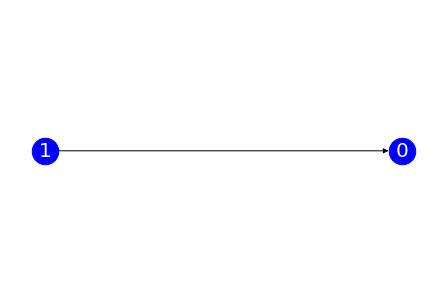

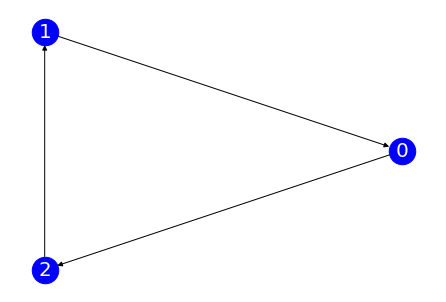

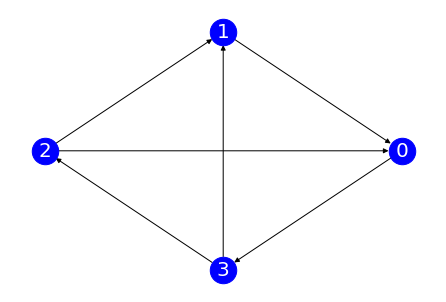

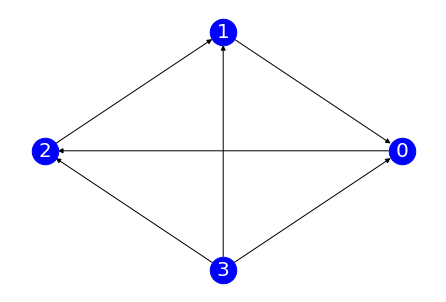

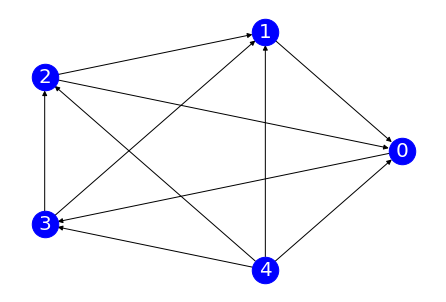

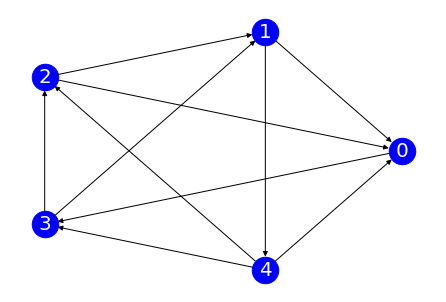

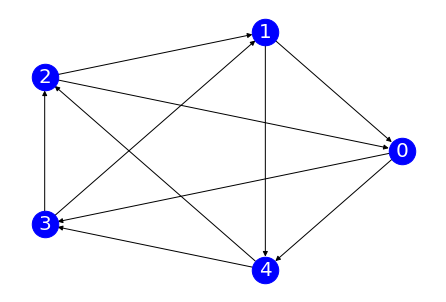

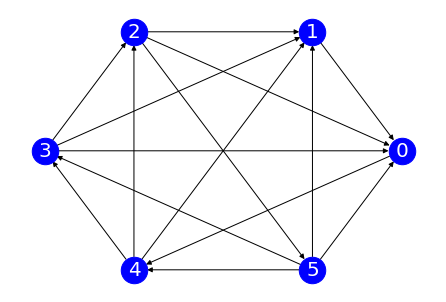

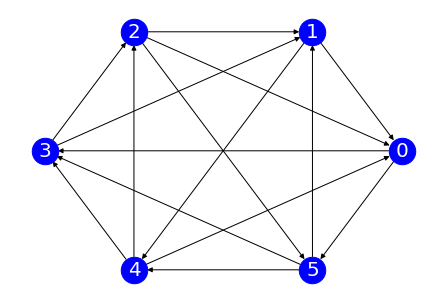

In [22]:
for g in graphs: 
    display_wt(g)

In [23]:
two_cand_tournament = all_gs_mus_dict[2][0]
print("Two candidate tournament ", two_cand_tournament.edges)

C_func = generate_function_formula(graphs, wt_dictionary)
print("Done creating the function formula.")

C_bg = generate_bg_formula(min_num_cands, 
                           max_num_cands, 
                           canonical_graphs,
                           wt_dictionary, 
                           possible_winners, 
                           embeddings,
                           two_cand_tournament
                          )
print("Done creating the BG formula.")

C_ar = generate_ar_formula(min_num_cands, 
                           max_num_cands, 
                           canonical_graphs, 
                           wt_dictionary, 
                           possible_winners, 
                           embeddings,
                           two_cand_tournament
                          )
print("Done creating the AR formula.")

C_bqr = generate_binary_qr_formula(canonical_graphs, wt_dictionary)
print("Done creating BQR formula")

C_bm = [[1]]


Two candidate tournament  [(1, 0)]
Done creating the function formula.
Done creating the BG formula.
Done creating the AR formula.
Done creating BQR formula


In [24]:
formula =  C_func + C_bg + C_ar + C_bqr + C_bm

print(f"The number of clauses in formula is {len(formula)}")
sat_solver = Glucose3()
for cl in formula:
    sat_solver.add_clause(cl)

if sat_solver.solve(): 
    print(f"There is a canonical tournament solution, satisfying the orbit condition, up to {max_num_cands} candidates that satisfies BG, AR, and BQR.")
    vm = sat_solver.get_model()
else: 
    print(f"There is no canonical tournament solution, satisfying the orbit condition, up to {max_num_cands} candidates that satisfies BG, AR, and BQR.")



The number of clauses in formula is 4954
There is no canonical tournament solution, satisfying the orbit condition, up to 6 candidates that satisfies BG, AR, and BQR.


## 2. Minimal set of tournaments to prove Proposition B.3

In [2]:
# helper function

def display_weighted_tourn(wt, edge_attr):
    """Display a weighted tournament with edge weights"""
    pos = nx.circular_layout(wt)
    nx.draw(wt, pos, font_size=20, node_color='blue', font_color='white',
            node_size=700, width=1, with_labels=True)
    
    edge_labels = nx.get_edge_attributes(wt, edge_attr)
    nx.draw_networkx_edge_labels(wt, pos, edge_labels=edge_labels, label_pos=0.3)
    plt.show()


In [3]:
# Paths to pickled weak tournaments
canonical_weighted_tournament_paths = {
    2: 'weighted_tourns/weighted_tourns_2.pkl',
    3: 'weighted_tourns/weighted_tourns_3.pkl',
    4: 'weighted_tourns/weighted_tourns_4.pkl',
}

# Load all the canonical weighted tournaments
canonical_weighted_tournaments = {nc: pickle.load(open(canonical_weighted_tournament_paths[nc], 'rb'))
                                  for nc in range(2,5)}


In [4]:

def generate_wt_dictionary_with_resoluteness(wts):
    """
    takes a dictionary of (weak) tournaments and returns a dictionary (t, ws) -> int
    t is a tournament in 'possible_winners' and ws is a winning set on t satisfying the orbit condition
    """
    wt_dictionary = {}
    wt_w_id = 1
    for num_cands in wts.keys():
        for wt in wts[num_cands]: 
            for c in range(num_cands): 
                wt_dictionary.update({(wt, c): wt_w_id})
                wt_w_id += 1
            
    return wt_dictionary

In [5]:
def generate_function_formula(graphs, wt_dictionary): 
    """
    takes a list of all graphs 'graphs' and a dictionary of possible winners on those graphs 'wwt_dictionary'
    returns CNF clauses ensuring that only one winning set will be chosen per graph
    """
    C_func = list()
    for t in graphs:  

        # get the list of all atomic formulas describing a possible winning set
        poss_ws = [wt_dictionary[(_t, w)] for _t,w in wt_dictionary.keys() if _t == t]
        #print(poss_ws)
        # NOTE: we use equality rather than testing for graph isomporphism.  This makes sense since
        # graphs is the set of the networkx objects representing the canonical tournaments and 
        # the keys of wwt_dictionary are tuples where the first components is an object from this lest. 
        C_func.append(poss_ws) # one of the possible winning sets is the winner
        for pairs in combinations(poss_ws, 2):
            # add a clause saying that it is not the case that two possible winning sets are associated 
            # with a weighted tournament
            C_func.append([0 - pairs[0], 0 - pairs[1]])

    return C_func



In [6]:
# helper function that transforms edges under an isomorphism
edge_conv = lambda e, iso: (iso[e[0]], iso[e[1]])

def preserves_weights(small_g, big_g, iso, edge_attr, verbose=False):
    """
    takes weighted tournament small_g, big_g and an embedding iso from small_g to big_g
    returns true if iso preserves weights from small_g to big_g
    """
    for e in small_g.edges:
        if small_g.edges[e][edge_attr] != big_g.edges[edge_conv(e, iso)][edge_attr]:
            if verbose:
                print("The edge {} in the small graph embeds into the edge {} in the big graph, but the weight of {} in the small graph doesn't match the weight of {} in the big graph.".format(e, edge_conv(e, iso), e, edge_conv(e, iso)))
            return False
    return True

def is_embedding(small_g, big_g, iso):
    """
    iso is an isomorphism from small_g to a subgraph of big_g,
    but we must check whether iso is an embedding. 
    returns True if iso is an embedding of small_g into big_g. 
    
    Returns True if for every pair of candidates c1 and c2 in small_g, 
    if there is an edge between iso[c1] and iso[c2] in big_g, then 
    there is an edge between c1 and c2 in small_g
    """
    for c1, c2 in product(small_g.nodes, small_g.nodes): 
        if big_g.has_edge(iso[c1],iso[c2]) and not small_g.has_edge(c1,c2):
            return False
    return True    

def find_embeddings(min_num_cands, max_num_cands, canonical_graphs, edge_attr):
    """
    find embeddings of graphs in 'canonical_graphs',
    embeddings of n-tournaments to (n+1)-tournaments, for n=min_num_cands,...,max_num_cands-1
    """
    embeddings = list()

    for nc in range(min_num_cands, max_num_cands): 
        # for each number of candidate between min_num_cands and max_num_cands - 1  

        for g1 in canonical_graphs[nc]: 
            # for each canonical graph of size nc    

            for g2 in canonical_graphs[nc+1]:
                # for each canonical graph of size nc+1

                seen_ranges = set()

                for iso in nx.algorithms.isomorphism.GraphMatcher(g2, g1, edge_match=edge_compare).subgraph_isomorphisms_iter():
                    # for each isomporphism from g1 to a subgraph of g2

                    # NOTE: iso is a dictionary associating a subset of nodes from g2 to the nodes in g1
                    # It's easier to think about the isomorphism as a mapping from the smaller graph g1 
                    # into the bigger graph g2:
                    inverse_iso = {v:k for k,v in iso.items()}

                    rng = tuple(sorted(iso.keys())) # the range of the isomorphism (nodes in the bigger graph)
                    if not rng in seen_ranges and is_embedding(g1, g2, inverse_iso) and \
                    preserves_weights(g1, g2, inverse_iso, edge_attr):
                        # if haven't seen the range yet, g1 is an embedding into g2, 
                        # and the embedding preserves edge weights
                        seen_ranges.add(rng)
                        # record the smaller graph g1, larger graph g2 and isomorphism from g1 to g2
                        embeddings.append((g1, g2, inverse_iso))  
    return embeddings

In [7]:
def generate_bg_formula(min_num_cands, 
                        max_num_cands, 
                        canonical_graphs, 
                        wwt_dictionary, 
                         embeddings,
                        edge_attr): 
    """
    returns CNF clauses expressing binary gamma
    """
    C_bg = list()
    
    can_2_tourn_dict = {[e[2]['weight'] for e in wt.edges(data=True)][0]: wt  
                        for wt in canonical_graphs[2]}

    can_2_tourn_maj_pref_cand = [c for c in can_2_tourn_dict[2].nodes 
                                 if can_2_tourn_dict[2].out_degree(c) == 1][0]
    
    can_2_tourn_min_pref_cand = [c for c in can_2_tourn_dict[2].nodes 
                                 if c != can_2_tourn_maj_pref_cand][0]

    C_bg = list()

    for nc in range(min_num_cands, max_num_cands + 1):

        for t1 in canonical_graphs[nc]:
            # for each canonical weighted tournament for nc candidates
            
            for emb in [_emb for _emb in embeddings if _emb[0] == t1]: 
                # for each possible embedding from t1 into a canonical majority graph emb[1]
                
                t2 = emb[1]
                # t2 is a canonical weighted tournament for nc+1 candidates, which t1 embeds into
                
                if t2 in canonical_graphs[nc+1]:
                    new_cand = list(set(emb[1].nodes).difference(set(emb[2].values())))[0]
                    # new_cand is the candidate in t2 not in the range of the embedding from t1 to t2

                    for cand in t1.nodes:
                        cand_t2 = emb[2][cand]
                        if (cand_t2, new_cand) in t2.edges: # if cand_t2 is majority preferred to new_cand

                            # if cand is a winner in t1
                            clause = [-wwt_dictionary[(t1, cand)]]

                            # if cand_t2 is majority preferred to new_cand by the right margin
                            can_2_tourn = can_2_tourn_dict[t2.edges[(cand_t2, new_cand)][edge_attr]]
                            clause += [-wwt_dictionary[(can_2_tourn, can_2_tourn_maj_pref_cand)]]    

                            # then cand_t2 must be the winner in t2
                            clause += [wwt_dictionary[(t2, cand_t2)]]                       

                            if tuple(clause) in clause_reasons.keys(): 
                                clause_reasons[tuple(clause)].append(("BG", emb[0], emb[1], emb[2]))
                            else: 
                                clause_reasons[tuple(clause)] = [("BG", emb[0], emb[1], emb[2])]

                            C_bg.append(clause)

                        elif (new_cand, cand_t2) in t2.edges: # if cand_t2 is minority preferred to new_cand

                            # if cand is a winner in t2
                            clause = [-wwt_dictionary[(t1, cand)]]

                            # if minority rule on two-candidate tournament with same weight as cand_t2 <- new_cand
                            can_2_tourn = can_2_tourn_dict[t2.edges[(new_cand, cand_t2)][edge_attr]]
                            clause += [-wwt_dictionary[(can_2_tourn, can_2_tourn_min_pref_cand)]]

                            # then cand_t2 must be the winner in t2
                            clause += [wwt_dictionary[(t2, cand_t2)]]                       
                            
                            if tuple(clause) in clause_reasons.keys(): 
                                clause_reasons[tuple(clause)].append(("BG", emb[0], emb[1], emb[2]))
                            else: 
                                clause_reasons[tuple(clause)] = [("BG", emb[0], emb[1], emb[2])]

                            C_bg.append(clause)

                        else:
                            raise Exception
                        
    return C_bg

In [8]:

min_num_cands,max_num_cands = 2, 4

edge_attr = 'weight'

def edge_compare_helper(dict1, dict2, edge_attr):
    return dict1[edge_attr] == dict2[edge_attr]

edge_compare = (lambda edge_attr: lambda dict1, dict2: edge_compare_helper(dict1, dict2, edge_attr))(edge_attr)

canonical_graphs = canonical_weighted_tournaments

graphs = [mg for nc in range(min_num_cands, max_num_cands + 1) for mg in  canonical_graphs[nc]]

wt_dictionary = generate_wt_dictionary_with_resoluteness(canonical_weighted_tournaments)
print("Done creating the encoding.")

embeddings = find_embeddings(min_num_cands, max_num_cands, canonical_weighted_tournaments, edge_attr)
print("Done creating the embeddings.")


Done creating the encoding.


KeyboardInterrupt: 

In [ ]:
C_func = generate_function_formula(graphs, wt_dictionary)
print("Done creating the function formula.\n\n")

clause_reasons = dict() # global variable recording reasons for some of the clauses

C_bg = generate_bg_formula(min_num_cands, 
                           max_num_cands, 
                           canonical_weighted_tournaments, 
                           wt_dictionary, 
                           embeddings,
                           edge_attr)
print("Done creating the BG clauses")


# uncomment to see the model (list of literals that are true)
#print(sat_solver.get_model())

In [ ]:
formula = C_func + C_bg
sat_solver = Glucose3()
for cl in formula:
    sat_solver.add_clause(cl)

if sat_solver.solve(): 
    print(f"There is a canonical tournament solution up to {max_num_cands} candidates that satisfies BG and QR.")
    vm = sat_solver.get_model()
else: 
    print(f"There is no canonical tournament solution up to {max_num_cands} candidates that satisfies BG and QR.")


In [71]:
main_formula_cnf = CNF()
for cl in  C_func + C_bg:
    main_formula_cnf.append(cl)

print(f"There are {len([cl for cl in main_formula_cnf])} clauses in the main formula")


There are 38092 clauses in the main formula


In [72]:
## Use PicoMUS to find an MUS

# main_formula_cnf.to_file("./picosat/qr_bg.cnf")

# !./picosat/picomus -v qr_bg.cnf qr_bg_output.cnf

In [73]:
mus_cnf = CNF()

mus_cnf.from_file("./mus_cnfs/qr_bg_output.cnf")

print(f"There are {len([cl for cl in mus_cnf])} clauses in the mus")


There are 9297 clauses in the mus


In [74]:
sat_solver = Glucose3()
for cl in mus_cnf:
    sat_solver.add_clause(cl)

if sat_solver.solve(): 
    print(f"There is a canonical tournament solution up to {max_num_cands} candidates that satisfies BG and QR.")
    vm = sat_solver.get_model()
else: 
    print(f"There is no canonical tournament solution up to {max_num_cands} candidates that satisfies BG and QR.")


There is no canonical tournament solution up to 4 candidates that satisfies BG and QR.


In [75]:
def get_ids_in_cnf(cnf):
    _ids = list()
    for cl in cnf: 
        for l in cl: 
            if l > 0: 
                _ids.append(l)
            if l < 0: 
                _ids.append(-l)

    return list(set(_ids))

ids_main_formula_cnf = get_ids_in_cnf(main_formula_cnf)
ids_mus_cnf = get_ids_in_cnf(mus_cnf)

print(f"The number of ids in the main formula {len(ids_main_formula_cnf)}")
print(f"The number of ids in the mus {len(ids_mus_cnf)}")


The number of ids in the main formula 8172
The number of ids in the mus 4781


In [76]:
def graphs_ws_from_ids(ids, wt_dictionary):
    """returns two lists: the list of graphs associated with the ids and the list of graph, ws pairs for the ids"""
    _g_ws = list()
    _gs = list()
    for g,ws in wt_dictionary.keys(): 
        if wt_dictionary[(g, ws)] in ids: 
            _g_ws.append((g, ws))
            _gs.append(g)
            
    return list(set(_g_ws)), list(set(_gs))

graphs_ws_main_formula, graphs_main_formula = graphs_ws_from_ids(ids_main_formula_cnf, wt_dictionary)
graphs_ws_mus, graphs_mus = graphs_ws_from_ids(ids_mus_cnf, wt_dictionary)


print(f"The number of graphs mentioned in the main formula {len(graphs_main_formula)}")
print(f"The number of graphs mentioned in the mus {len(graphs_mus)}")


The number of graphs mentioned in the main formula 2086
The number of graphs mentioned in the mus 1622


In [77]:
def get_graphs_mentioned_in_reasons(cnf):
    _reason_gs = list()
    for cl in cnf: 
        if tuple(cl) in clause_reasons.keys():
            for r in clause_reasons[tuple(cl)]:
                _reason_gs.append(r[1])
                _reason_gs.append(r[2])
    return list(set(_reason_gs))

reason_graphs_main_formula = get_graphs_mentioned_in_reasons(main_formula_cnf)
reason_graphs_mus = get_graphs_mentioned_in_reasons(mus_cnf)


print(f"The number of graphs mentioned in reasons for the main formula {len(reason_graphs_main_formula)}")
print(f"The number of graphs mentioned in reasons for the mus {len(reason_graphs_mus)}")


The number of graphs mentioned in reasons for the main formula 2086
The number of graphs mentioned in reasons for the mus 6


In [78]:
all_gs_main_formula = list(set(graphs_main_formula + reason_graphs_main_formula))
all_gs_mus = list(set(graphs_mus + reason_graphs_mus))


print(f"The number of graphs mentioned in the main formula {len(all_gs_main_formula)}")

all_gs_main_formula_dict = dict()
all_gs_main_formula_dict[2] = [g for g in all_gs_main_formula if len(g.nodes) == 2]
all_gs_main_formula_dict[3] = [g for g in all_gs_main_formula if len(g.nodes) == 3]
all_gs_main_formula_dict[4] = [g for g in all_gs_main_formula if len(g.nodes) == 4]
print("In the main formula, the following graphs are mentioned:")
print(f"2 candidate graphs: {len(all_gs_main_formula_dict[2])}")
print(f"3 candidate graphs: {len(all_gs_main_formula_dict[3])}")
print(f"4 candidate graphs: {len(all_gs_main_formula_dict[4])}")

print()
print(f"The number of graphs mentioned in the mus {len(all_gs_mus)}")

all_gs_mus_dict = dict()
all_gs_mus_dict[2] = [g for g in all_gs_mus if len(g.nodes) == 2]
all_gs_mus_dict[3] = [g for g in all_gs_mus if len(g.nodes) == 3]
all_gs_mus_dict[4] = [g for g in all_gs_mus if len(g.nodes) == 4]

print("In the mus, the following graphs are mentioned:")
print(f"2 candidate graphs: {len(all_gs_mus_dict[2])}")
print(f"3 candidate graphs: {len(all_gs_mus_dict[3])}")
print(f"4 candidate graphs: {len(all_gs_mus_dict[4])}")

pickle.dump(all_gs_mus_dict, open("./graphs_for_impossibilities/all_gs_mus_dict.pkl", "wb"))

The number of graphs mentioned in the main formula 2086
In the main formula, the following graphs are mentioned:
2 candidate graphs: 6
3 candidate graphs: 160
4 candidate graphs: 1920

The number of graphs mentioned in the mus 1622
In the mus, the following graphs are mentioned:
2 candidate graphs: 6
3 candidate graphs: 160
4 candidate graphs: 1456


In [83]:
canonical_graphs = all_gs_mus_dict

graphs = [mg for nc in range(min_num_cands, max_num_cands + 1) for mg in  canonical_graphs[nc]]

wt_dictionary = generate_wt_dictionary_with_resoluteness(canonical_graphs)
print("Done creating the encoding.")

embeddings = find_embeddings(min_num_cands, max_num_cands, canonical_graphs, edge_attr)
print("Done creating the embeddings.")

C_func_mus = generate_function_formula(graphs, wt_dictionary)
print("Done creating the function formula.")

C_bg_mus = generate_bg_formula(min_num_cands, 
                               max_num_cands, 
                               canonical_graphs,
                               wt_dictionary, 
                               embeddings,
                               edge_attr)

print("Done creating the BG formula.")


Done creating the encoding.
Done creating the embeddings.
Done creating the function formula.
Done creating the BG formula.


In [84]:
formula_mus =  C_func_mus + C_bg_mus
print(f"The number of clauses in formula is {len(formula_mus)}")

sat_solver = Glucose3()
for cl in formula_mus:
    sat_solver.add_clause(cl)

print()
if sat_solver.solve(): 
    print(f"There is a canonical tournament solution up to {max_num_cands} candidates that satisfies BG and QR.")
    vm = sat_solver.get_model()
else: 
    print(f"There is no canonical tournament solution up to {max_num_cands} candidates that satisfies BG and QR.")


The number of clauses in formula is 29276

There is no canonical tournament solution up to 4 candidates that satisfies BG and QR.


## A second way to find a minimal set of weighted tournament to prove Proposition B.3

Rather than using an MUS as above, another approach is to iteratively remove tournaments from the intial set only keeping the ones needed for an unsatisfiability result.  Of course, the resulting minimal set is highly dependent on the order in which we try removing tournaments.   

In [9]:
min_num_cands,max_num_cands = 2, 4

edge_attr = 'weight'

def edge_compare_helper(dict1, dict2, edge_attr):
    return dict1[edge_attr] == dict2[edge_attr]

edge_compare = (lambda edge_attr: lambda dict1, dict2: edge_compare_helper(dict1, dict2, edge_attr))(edge_attr)

canonical_graphs = canonical_weighted_tournaments

graphs = [mg for nc in range(min_num_cands, max_num_cands + 1) for mg in  canonical_graphs[nc]]

wt_dictionary = generate_wt_dictionary_with_resoluteness(canonical_graphs)
print("Done creating the encoding.")

embeddings = find_embeddings(min_num_cands, max_num_cands, canonical_graphs, edge_attr)
print("Done creating the embeddings.")

clause_reasons = dict() # global variable recording reasons for some of the clauses

C_func = generate_function_formula(graphs, wt_dictionary)
print("Done creating the function formula.")

C_bg = generate_bg_formula(min_num_cands, 
                         max_num_cands, 
                         canonical_graphs, 
                         wt_dictionary, 
                         embeddings,
                         edge_attr)
print("Done creating the BG clauses")


Done creating the encoding.
Done creating the embeddings.
Done creating the function formula.
Done creating the BG clauses


In [10]:
formula = C_func + C_bg
sat_solver = Glucose3()
for cl in formula:
    sat_solver.add_clause(cl)

if sat_solver.solve(): 
    print(f"There is a canonical tournament solution up to {max_num_cands} candidates that satisfies BG and QR.")
    vm = sat_solver.get_model()
else: 
    print(f"There is no canonical tournament solution up to {max_num_cands} candidates that satisfies BG and QR.")


There is no canonical tournament solution up to 4 candidates that satisfies BG and QR.


In [11]:
%%time 

gs_to_remove = list()
for g in tqdm(canonical_weighted_tournaments[4] + canonical_weighted_tournaments[3]): 
        
    removed_gs = gs_to_remove + [g]
    
    removed_ids = [wt_dictionary[(_g, ws)] for rem_g in removed_gs for _g, ws in wt_dictionary.keys() if _g == rem_g ]
    
    C_bg_new = [clause for clause in C_bg if not any([gid in clause or -gid in clause for gid in removed_ids])]

    formula =  C_func +  C_bg_new
    sat_solver = Glucose3()
    for cl in formula:
        sat_solver.add_clause(cl)

    if sat_solver.solve(): 
        pass
        #print(f"+++++There is a neutral weighted tournament solution up to {max_num_cands} candidates satisfying quasi-resoluteness and binary gamma.")
    else: 
        gs_to_remove.append(g)
        C_bg = C_bg_new
        #print(f"There is no neutral weighted tournament solution up to {max_num_cands} candidates satisfying quasi-resoluteness and binary gamma.")



CPU times: user 7h 7min 50s, sys: 1min 50s, total: 7h 9min 40s
Wall time: 7h 17min 54s


In [12]:
wts_for_impossibility = [wt for wt in canonical_weighted_tournaments[4] if wt not in gs_to_remove]
wts_for_impossibility += [wt for wt in canonical_weighted_tournaments[3] if wt not in gs_to_remove]
wts_for_impossibility += canonical_weighted_tournaments[2]

print(f"Minimal number of weighted tournaments with 4 candidates: {len(wts_for_impossibility)}")

pickle.dump(wts_for_impossibility, open("./graphs_for_impossibilities/wts_for_impossibility.pkl", "wb"))

Minimal number of weighted tournaments with 4 candidates: 716


In [13]:
min_set_canonical_weighted_tournaments = dict()
min_set_canonical_weighted_tournaments[2] = [wt for wt in wts_for_impossibility if len(wt.nodes) == 2]
min_set_canonical_weighted_tournaments[3] = [wt for wt in wts_for_impossibility if len(wt.nodes) == 3]

min_set_canonical_weighted_tournaments[4] = [wt for wt in wts_for_impossibility if len(wt.nodes) == 4]

for nc in min_set_canonical_weighted_tournaments.keys(): 
    print(f"There are {len(min_set_canonical_weighted_tournaments[nc])} weighted tournaments with {nc} candidates.")

There are 6 weighted tournaments with 2 candidates.
There are 140 weighted tournaments with 3 candidates.
There are 570 weighted tournaments with 4 candidates.


In [14]:
min_num_cands,max_num_cands = 2, 4

canonical_graphs = min_set_canonical_weighted_tournaments

graphs = [mg for nc in range(min_num_cands, max_num_cands + 1) for mg in canonical_graphs[nc]]

wt_dictionary = generate_wt_dictionary_with_resoluteness(canonical_graphs)
print("Done creating the encoding.")

C_func = generate_function_formula(graphs, wt_dictionary)
print("Done creating the function formula.")

embeddings = find_embeddings(min_num_cands, max_num_cands, canonical_graphs, edge_attr)
print("Done creating the embeddings.")

C_bg = generate_bg_formula(min_num_cands, 
                           max_num_cands, 
                           canonical_graphs, 
                           wt_dictionary, 
                           embeddings,
                           edge_attr)
print("Done creating the BG clauses")

Done creating the encoding.
Done creating the function formula.
Done creating the embeddings.
Done creating the BG clauses


In [15]:
formula = C_func + C_bg

sat_solver = Glucose3()
for cl in formula:
    sat_solver.add_clause(cl)

if sat_solver.solve(): 
    print(f"There is a canonical weighted tournament solution up to {max_num_cands} candidates that satisfies the orbit condition, QR and BG.")
else: 
    print(f"There is no canonical weighted tournament solution up to {max_num_cands} candidates that satisfies the orbit condition, QR and BG.")


There is no canonical weighted tournament solution up to 4 candidates that satisfies the orbit condition, QR and BG.
